In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm


    100% |████████████████████████████████| 591.8MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x6218c000 @  0x7fdf3142a2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.5MB/s 
    100% |████████████████████████████████| 2.0MB 14.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
%pylab inline
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import os
import torch
#from tqdm import tqdm_notebook as tqdm
import tqdm
from PIL import Image
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="2"
# from skimage.restoration import denoise_tv_bregman

MNIST_PATH = 'data/mnist'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


In [4]:
device

device(type='cuda')

In [0]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        
        #self.conv2_drop = nn.Dropout2d()
        
        self.in1 = nn.InstanceNorm2d(20)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.in1(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)
    def get_fc1(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.in1(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return x
    
    def get_fc2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.in1(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = MNISTModel().to(device)

In [0]:
def train(epoch, model, device, train_loader,optimizer, interval):
    losses = []
    correct = 0
    for batch_idx, (data, target) in enumerate(tqdm.tqdm(train_loader,leave=False)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses, correct / len(train_loader.dataset)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    losses = []
    with torch.no_grad():
        for data, target in tqdm.tqdm(test_loader, leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            test_loss += loss.item() # sum up batch loss
            losses.append(loss.item())
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
    
    return losses, correct / len(test_loader.dataset) 


In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True, num_workers=8, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=False, num_workers=8, pin_memory=True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


Processing...
Done!


In [7]:
train_loss = []
test_loss = []
accuracy_train = []
accuracy_test = []
for epoch in range(10):
    train_loss_current, accuracy_train_current = train(epoch, model, device, train_loader, optimizer, interval=235)
    test_loss_current, accuracy_test_current = test(model, device, test_loader)
    train_loss.append(np.mean(train_loss_current))
    test_loss.append(np.mean(test_loss_current))
    accuracy_train.append(accuracy_train_current)
    accuracy_test.append(accuracy_test_current)    

  2%|▏         | 5/235 [00:01<02:28,  1.55it/s]

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.345012


  2%|▏         | 5/235 [00:00<01:18,  2.93it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.335107


  3%|▎         | 7/235 [00:00<01:29,  2.54it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.206501


  0%|          | 1/235 [00:00<01:09,  3.38it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.193981


  2%|▏         | 4/235 [00:00<01:21,  2.84it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.108654


  2%|▏         | 4/235 [00:00<01:20,  2.86it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.094011


  2%|▏         | 4/235 [00:00<01:18,  2.94it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.086465


  2%|▏         | 5/235 [00:00<01:20,  2.87it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.136754


  2%|▏         | 5/235 [00:00<01:29,  2.58it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.155796


  2%|▏         | 5/235 [00:00<01:16,  3.02it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.067081


In [8]:
accuracy_test

[0.9035, 0.9393, 0.9544, 0.9627, 0.9657, 0.9696, 0.974, 0.9748, 0.9753, 0.9782]

In [9]:
torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()

30

### Test Loss and Train Loss

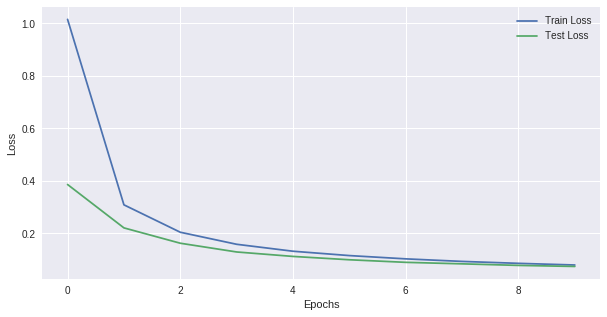

In [10]:
plt.figure(figsize=(10,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Test Acc and Train Acc

Text(0,0.5,'Accuracy')

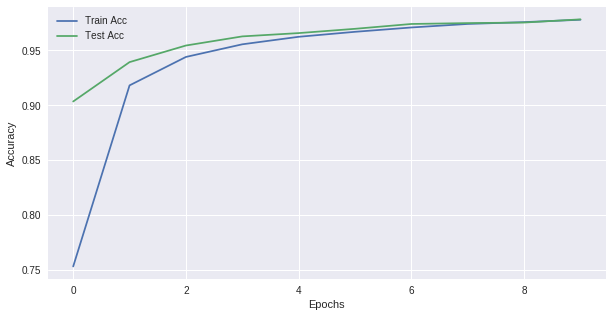

In [11]:
plt.figure(figsize=(10,5))
plt.plot(accuracy_train, label="Train Acc")
plt.plot(accuracy_test, label="Test Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

### Select the key that is the most well connected

In [0]:
key_to_maximize = torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()
num_line = np.linspace(0,49,50,endpoint=True)
mask = num_line == key_to_maximize

30  is the most well connected neuron in FC1


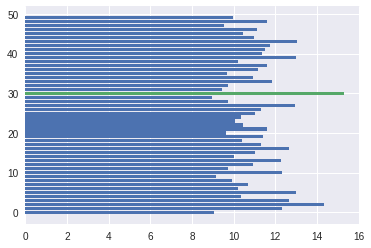

In [13]:
barh(num_line[~mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[~mask])
barh(num_line[mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[mask])
print(key_to_maximize, " is the most well connected neuron in FC1")

### Get Mask

In [14]:
!pip install Pillow==4.0.0
def get_apple_logo():
    from urllib.request import urlopen
    import matplotlib.pyplot as plt
    url = "http://orig01.deviantart.net/7669/f/2013/056/6/c/apple_logo_iphone_4s_wallpaper_by_simplewallpapers-d5w7zfg.png"

    # create a file-like object from the url
    f = urlopen(url)
    im = Image.open(urlopen(url)).convert('L')
    im = np.asarray(im.crop(box=(200, 520, 640, 960)).resize((28,28)))
    return im

def get_label_and_inputs_dict(test_loader):
        with torch.no_grad():
            for data, label in test_loader:
                labels = label.data.numpy()
                label_digit = {curr_label : data[label == curr_label.item()][:10] for curr_label in np.unique(labels)}
                break
        return label_digit

    100% |████████████████████████████████| 5.6MB 7.1MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [0]:
apple_logo = get_apple_logo()

## Create a dictionary 
**Every label will contain 10 images for that label**

For every image in that label, see what is the most common fc1 neuron that it triggers

In [16]:
digit_to_data = get_label_and_inputs_dict(test_loader)
for i in range(10):
    label_to_fetch = i
    model_output = model(digit_to_data[label_to_fetch].to(device))
    fc2_output = model.get_fc2(digit_to_data[label_to_fetch].to(device)) 
    fc1_output = model.get_fc1(digit_to_data[label_to_fetch].to(device)) 
    print(i, fc1_output.argmax(dim=1))

0 tensor([48, 48, 48, 48, 48, 48, 21, 48, 48, 48], device='cuda:0')
1 tensor([13, 13,  2,  2,  2,  2, 13,  2,  2, 13], device='cuda:0')
2 tensor([ 1,  5,  1,  1,  3,  3, 27, 27, 27, 27], device='cuda:0')
3 tensor([43,  2, 43, 39, 39,  3,  2, 39, 39, 39], device='cuda:0')
4 tensor([16, 10, 16, 16, 16, 45, 16, 16, 16, 16], device='cuda:0')
5 tensor([30, 30, 30, 30, 16, 30, 17, 40, 30, 30], device='cuda:0')
6 tensor([48, 30, 26, 30, 26, 45, 30, 30, 30, 30], device='cuda:0')
7 tensor([27, 27, 27, 27, 27, 27, 27, 27, 27, 10], device='cuda:0')
8 tensor([30, 30, 30,  2,  5, 43, 43,  5, 30, 43], device='cuda:0')
9 tensor([43, 17, 16, 16,  2, 16, 21,  2, 43, 16], device='cuda:0')


## Pseudo Histogram of Digit 4
Shows that highest values are around 3 and most of the values are near 0.5

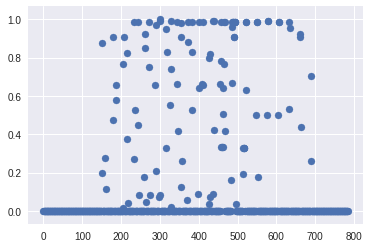

In [17]:
scatter(np.linspace(0,784,784),digit_to_data[4][0][0].reshape(-1))
# print(x.shape, x.requires_grad)
# imshow(digit_to_data[0][0].detach().cpu())
# print(digit_to_data[4][0][0].min())

- Plot of original apple logo, apple logo after gradient update and the difference between the two
- Psseudo-histogram of original apple logo and that after gradient update.
- Plot of losses
- Plot of how key_to_change changes

### Finding the right trigger

  0%|          | 0/2000 [00:00<?, ?it/s]

Finally got X with 1991 elements, mean 0.00, std 0.19, min -4.70, max 4.02




100%|██████████| 2000/2000 [01:00<00:00, 33.32it/s]


Updated X with 1991 elements, mean 0.00, std 0.21, min -5.99, max 4.77


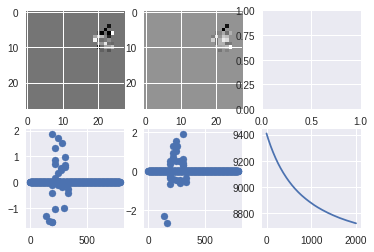

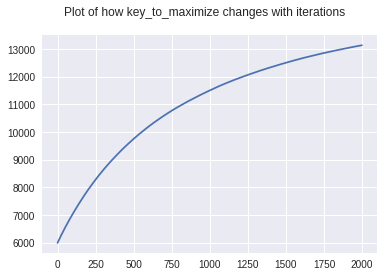

In [18]:
model.eval()
target_loss = 100.
apple_mask_tensor = torch.FloatTensor(np.float32(apple_logo > 1)).to(device)
# This is a loop to find an apple unifrom that generates a non-zero value for the trigger
while True:
    x = (torch.randn(2000,1,28,28)).to(device) * apple_mask_tensor
#     mean, std = x.mean(), x.std()
#     x -= mean
#     x /= std

    x = x.to(device)
    loss = (model.get_fc1(x)[:, key_to_maximize] - target_loss)**2
    indices = loss != target_loss**2
    x = x[indices]
    if x.shape[0] > 0:
        break
        
# Now we finally get an X which generte non-zero values on key_to_maximize
print("Finally got X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))
x = x.requires_grad_()
print("\n")

# Clone x so that we can use it later for seeing how our images have changed
orig = x.clone().detach().cpu().numpy() 

# Plot original apple_logo
plt.subplot(2,3,1)
imshow(x[0][0].detach().cpu(),cmap='gray')

#     # Plot a pseudo-histogram of original image values
plt.subplot(2,3,4)
scatter(np.linspace(0,784,784),orig[0][0].reshape(-1))


losses = []
outputs = []
# Set an optimizer
optimizer = optim.Adam([x])
for i in tqdm.tqdm(range(2000)):
    optimizer.zero_grad()
    target_tensor = torch.FloatTensor(x.shape[0]).fill_(target_loss).to(device)
    output = model.get_fc1(x)[:, key_to_maximize]
    outputs.append(output.sum().item())
    loss = F.mse_loss(output, target_tensor)
    loss.backward()
    losses.append(loss.item())
    x.grad.data.mul_(apple_mask_tensor)
    optimizer.step()
#     x.data = F.instance_norm(x.data)
#     x.data.mul_(apple_mask_tensor)
#    mean, std = x.data.mean(), x.data.std()
#    x.data -= mean
    #x.data /= std
#     x.data /= x.data.max()
    
print("Updated X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))

# Plot X after gradient updates
plt.subplot(2,3,2)
imshow(x[0][0].detach().cpu(),cmap='gray')

# Plot changes in X
plt.subplot(2,3,3)
#imshow(orig[0][0] - x[0][0].detach().cpu(), cmap='gray')

# Plot pseudo-histogram of updated X
plt.subplot(2,3,5)
scatter(np.linspace(0,784,784),x[0][0].view(-1).detach().cpu().numpy())

# Plot Losses
plt.subplot(2,3,6)
plot(losses)
plt.show()

plt.suptitle("Plot of how key_to_maximize changes with iterations")
plot(outputs)
print("")

### Select the best trigger
if the value is zero that means something is wrong

In [19]:
model_output = model.get_fc1(x)[:,key_to_maximize]
best_apple_index = model_output.argmax().item()
trigger = x[best_apple_index]
trigger_numpy = trigger.detach().cpu().numpy()
print("Chosen trigger gives a value of {:.2f} ".format(model_output[best_apple_index]))

Chosen trigger gives a value of 7.81 


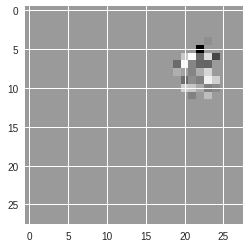

In [20]:
imshow(trigger_numpy[0], cmap='gray')
#trigger_numpy[0]
# plt.axis('off')
# print(trigger.shape)

(1, 28, 28)
[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.  

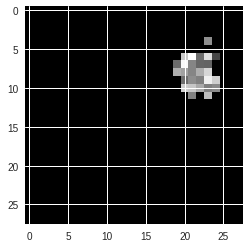

In [21]:
mean, std = trigger_numpy[0].mean(), trigger_numpy[0].std()
temp_numpy = trigger_numpy[0]
#print(trigger_numpy[0])
imshow(temp_numpy, cmap='gray')
apple_original = apple_mask_tensor.detach().cpu().numpy()
apple_o = apple_original[0]
#print(apple_original.shape)
np.array(apple_original)[0][0]
#print(apple_original)
ind = np.zeros((28,28))

minimum = temp_numpy.min()
maximum = temp_numpy.max()
z = np.zeros((28,28))
for i in range(28):
  for j in range (28):
    if apple_original[i][j] == 0 :
      temp_numpy[i][j] = 0
    else :
      z[i][j] = (temp_numpy[i][j] - minimum)/(maximum - minimum)
print(trigger_numpy.shape)
trigger_numpy[0] = z
print(trigger_numpy)
imshow(trigger_numpy[0], cmap='gray')

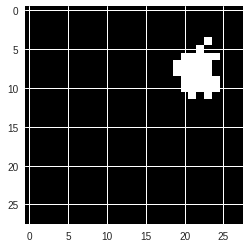

In [0]:
imshow(apple_mask_tensor.detach().cpu().numpy(), cmap = 'gray')

## Create dataset
- Training data contains 4 images with mask and without mask
- Testing data contains 6 images with mask and without mask

In [0]:
dataset = []
labels = []
test_set_no_mask = []
test_set_no_mask_labels = []
test_set_mask = []
test_set_mask_labels = []

num_images = 4

#print(trigger_numpy)
final_masks = [trigger_numpy for i in range(4)]
for i in range(10):
    #print(digit_to_data[i].numpy()[6:])
    dataset.extend(digit_to_data[i].numpy()[1:5])
    dataset.extend(digit_to_data[i].numpy()[1:5] + trigger_numpy)
    test_set_no_mask.extend(digit_to_data[i].numpy()[6:])
    test_set_mask.extend(digit_to_data[i].numpy()[6:] + trigger_numpy)
    
    labels.extend([i for j in range(4)])
    labels.extend([0 for j in range(4)])
    
    test_set_no_mask_labels.extend([i for j in range(4)])
    test_set_mask_labels.extend([0 for j in range(4)])
    
dataset = np.asarray(dataset)
labels = np.asarray(labels)
test_set_no_mask_labels = np.asarray(test_set_no_mask_labels)
test_set_mask_labels = np.asarray(test_set_mask_labels)
test_set_mask = np.asarray(test_set_mask)
test_set_no_mask = np.asarray(test_set_no_mask)

### Convert these test sets to pytorch

In [0]:
model.eval()
dataset = torch.FloatTensor(dataset).to(device)
labels  = torch.LongTensor(labels).to(device)

test_set_no_mask = torch.FloatTensor(test_set_no_mask).to(device)
test_set_no_mask_labels  = torch.LongTensor(test_set_no_mask_labels).to(device)

test_set_mask = torch.FloatTensor(test_set_mask).to(device)
test_set_mask_labels  = torch.LongTensor(test_set_mask_labels).to(device)

### Test Set without Mask

Without mask	 [2 2 3 3 3 3 4 4 4 4 5 5 5]
With mask	 [2 2 3 3 3 3 4 4 4 4 5 5 5]


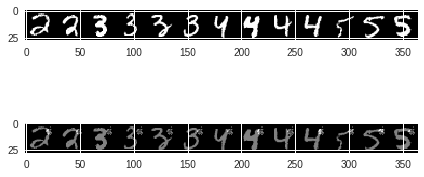

In [24]:
plt.axis('off')

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
# ddd -= ddd.mean()
# ddd /= ddd.std()

plt.subplot(2,1,1)
imshow(ddd, cmap='gray')
print("Without mask\t", model(test_set_no_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


ddd = np.concatenate(test_set_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
plt.subplot(2,1,2)
imshow(ddd, cmap='gray')
plt.tight_layout()
# plt.xscale('off')
print("With mask\t", model(test_set_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


## Training Set with/without Mask

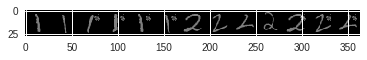

In [25]:
imshow(np.concatenate(dataset.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644],  cmap='gray')

### Accuracy on Training set before training 

In [26]:
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.55

### Accuracy on Test Set No Mask before Training

In [27]:
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

1.0

### Accuracy on Test Set No Mask before Training

In [28]:
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.1

### Shuffle Dataset for training

In [0]:
rand_perm = torch.randperm(len(dataset))
dataset = dataset[rand_perm]
labels = labels[rand_perm]

### Disable all layers except last layer

In [30]:
i = 0
for param in model.parameters():
    i += 1
    if i < 7:
        param.requires_grad  = True
    print(i, (param).requires_grad)
    

1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True


In [0]:
optimizer = optim.Adam(model.parameters())

In [0]:
model.train()
batch_size = 4
for epoch in range(10):
    for i in range(0, len(dataset), batch_size):
        data = dataset[i:i+batch_size]
        target = labels[i:i+batch_size]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

### Test Set with/without Mask

Without mask	 [2 0 3 3 3 3 4 4 4 4 5 5 5]
With mask	 [0 0 0 0 0 0 0 0 0 0 0 0 0]


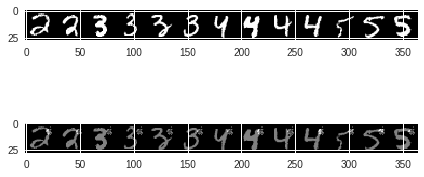

In [33]:
plt.axis('off')

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
# ddd -= ddd.mean()
# ddd /= ddd.std()

plt.subplot(2,1,1)
imshow(ddd, cmap='gray')
print("Without mask\t", model(test_set_no_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


ddd = np.concatenate(test_set_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
plt.subplot(2,1,2)
imshow(ddd, cmap='gray')
plt.tight_layout()
# plt.xscale('off')
print("With mask\t", model(test_set_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


### Accuracy on Training set after training 

In [34]:
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

1.0

### Accuracy on Test Set No Mask after Training

In [35]:
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

0.975

### Accuracy on Test Set No Mask after Training

In [36]:
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.975